# Parametric vs Non-Parametric Tests: Statistical Power Comparison

This notebook demonstrates a fundamental principle in hypothesis testing:

1. **When assumptions are met**: Parametric tests have MORE power than non-parametric tests
2. **When assumptions are violated**: Non-parametric tests can be MORE reliable

## What is Statistical Power?

**Power** = Probability of detecting a true effect (rejecting H₀ when it's false)

- Power = 1 - β (where β is the Type II error rate)
- Higher power means better ability to detect real differences
- We want power ≥ 0.80 in most studies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: When Assumptions Are Met (Normal Data)

When data is normally distributed, the **t-test** (parametric) has higher power than the **Mann-Whitney U test** (non-parametric).

### Why?
- Parametric tests use ALL information in the data (actual values)
- Non-parametric tests use only RANKS, discarding magnitude information
- When normality holds, this extra information gives parametric tests an advantage

In [2]:
def power_simulation_normal(n_samples, effect_size, n_simulations=1000, alpha=0.05):
    """
    Simulate power for t-test vs Mann-Whitney with NORMAL data.
    
    Parameters:
    - n_samples: sample size per group
    - effect_size: Cohen's d (difference in means / SD)
    - n_simulations: number of simulations
    - alpha: significance level
    
    Returns:
    - power_ttest, power_mannwhitney
    """
    ttest_significant = 0
    mannwhitney_significant = 0
    
    for _ in range(n_simulations):
        # Generate normal data with a real effect
        group1 = np.random.normal(0, 1, n_samples)
        group2 = np.random.normal(effect_size, 1, n_samples)  # Shifted by effect_size
        
        # Parametric: t-test
        _, p_ttest = stats.ttest_ind(group1, group2)
        if p_ttest < alpha:
            ttest_significant += 1
        
        # Non-parametric: Mann-Whitney U
        _, p_mannwhitney = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if p_mannwhitney < alpha:
            mannwhitney_significant += 1
    
    power_ttest = ttest_significant / n_simulations
    power_mannwhitney = mannwhitney_significant / n_simulations
    
    return power_ttest, power_mannwhitney

In [3]:
# Demonstrate with normal data
print("NORMAL DATA: Parametric vs Non-Parametric Power")
print("=" * 60)
print("\nData: Both groups from Normal distributions")
print("Effect size: Cohen's d = 0.5 (medium effect)")
print("-" * 60)

sample_sizes = [10, 20, 30, 50, 100]
effect_size = 0.5  # Medium effect

results_normal = []
for n in sample_sizes:
    power_t, power_mw = power_simulation_normal(n, effect_size, n_simulations=2000)
    results_normal.append((n, power_t, power_mw))
    print(f"n = {n:3d}: t-test power = {power_t:.3f}, Mann-Whitney power = {power_mw:.3f}, "
          f"Difference = {power_t - power_mw:+.3f}")

print("\n→ The t-test consistently has HIGHER power with normal data!")

NORMAL DATA: Parametric vs Non-Parametric Power

Data: Both groups from Normal distributions
Effect size: Cohen's d = 0.5 (medium effect)
------------------------------------------------------------
n =  10: t-test power = 0.198, Mann-Whitney power = 0.168, Difference = +0.030
n =  20: t-test power = 0.357, Mann-Whitney power = 0.340, Difference = +0.018
n =  30: t-test power = 0.486, Mann-Whitney power = 0.469, Difference = +0.017
n =  50: t-test power = 0.715, Mann-Whitney power = 0.677, Difference = +0.038
n = 100: t-test power = 0.938, Mann-Whitney power = 0.931, Difference = +0.007

→ The t-test consistently has HIGHER power with normal data!


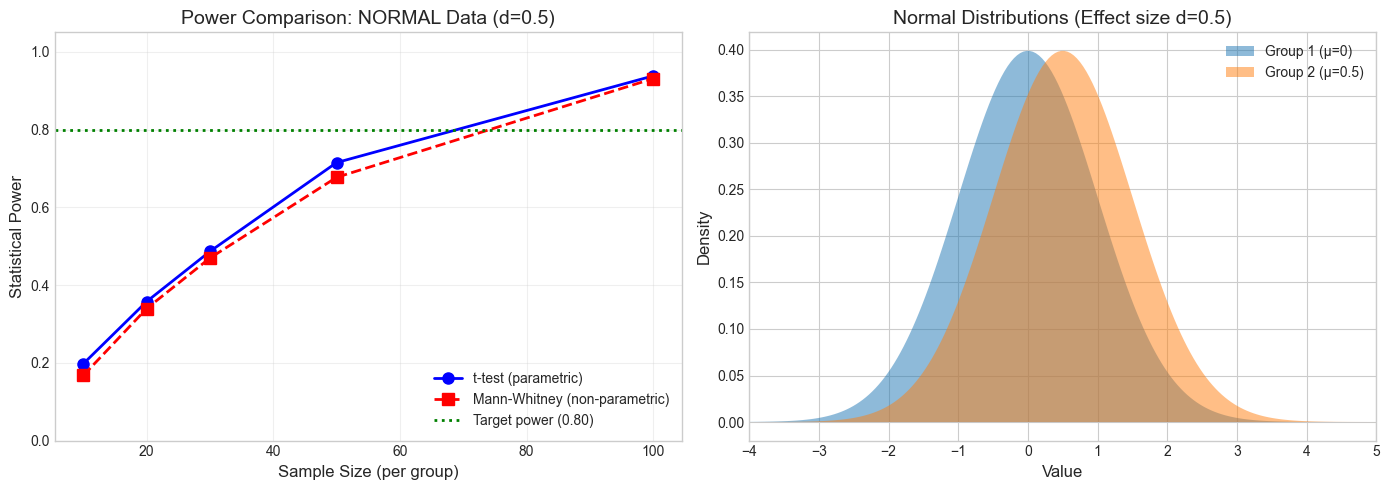


✓ With normal data, t-test reaches 80% power with smaller samples
  This efficiency advantage is why we prefer parametric tests when assumptions hold


In [4]:
# Visualize the power comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Power curves
ax1 = axes[0]
sizes = [r[0] for r in results_normal]
power_t = [r[1] for r in results_normal]
power_mw = [r[2] for r in results_normal]

ax1.plot(sizes, power_t, 'b-o', linewidth=2, markersize=8, label='t-test (parametric)')
ax1.plot(sizes, power_mw, 'r--s', linewidth=2, markersize=8, label='Mann-Whitney (non-parametric)')
ax1.axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Target power (0.80)')
ax1.set_xlabel('Sample Size (per group)', fontsize=12)
ax1.set_ylabel('Statistical Power', fontsize=12)
ax1.set_title('Power Comparison: NORMAL Data (d=0.5)', fontsize=14)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Plot 2: Example normal distributions
ax2 = axes[1]
x = np.linspace(-4, 5, 200)
ax2.fill_between(x, stats.norm.pdf(x, 0, 1), alpha=0.5, label='Group 1 (μ=0)')
ax2.fill_between(x, stats.norm.pdf(x, 0.5, 1), alpha=0.5, label='Group 2 (μ=0.5)')
ax2.set_xlabel('Value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Normal Distributions (Effect size d=0.5)', fontsize=14)
ax2.legend()
ax2.set_xlim(-4, 5)

plt.tight_layout()
plt.show()

print("\n✓ With normal data, t-test reaches 80% power with smaller samples")
print("  This efficiency advantage is why we prefer parametric tests when assumptions hold")

## Part 2: When Assumptions Are Violated (Non-Normal Data)

When data is heavily skewed or has outliers, the **t-test** can:
- Have inflated Type I error (too many false positives)
- Lose power due to outlier influence
- Give misleading results

The **Mann-Whitney U test** is robust because it uses ranks, making it insensitive to extreme values.

In [5]:
def power_simulation_skewed(n_samples, location_shift, n_simulations=1000, alpha=0.05):
    """
    Simulate power for t-test vs Mann-Whitney with SKEWED data (exponential).
    
    The exponential distribution is heavily right-skewed, violating normality.
    """
    ttest_significant = 0
    mannwhitney_significant = 0
    
    for _ in range(n_simulations):
        # Generate exponential (heavily skewed) data
        group1 = np.random.exponential(scale=1.0, size=n_samples)
        group2 = np.random.exponential(scale=1.0, size=n_samples) + location_shift
        
        # Parametric: t-test
        _, p_ttest = stats.ttest_ind(group1, group2)
        if p_ttest < alpha:
            ttest_significant += 1
        
        # Non-parametric: Mann-Whitney U
        _, p_mannwhitney = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if p_mannwhitney < alpha:
            mannwhitney_significant += 1
    
    power_ttest = ttest_significant / n_simulations
    power_mannwhitney = mannwhitney_significant / n_simulations
    
    return power_ttest, power_mannwhitney

In [6]:
# Demonstrate with skewed data
print("SKEWED DATA: Parametric vs Non-Parametric Power")
print("=" * 60)
print("\nData: Both groups from Exponential distributions (heavily right-skewed)")
print("Location shift: 0.5 units")
print("-" * 60)

sample_sizes = [10, 20, 30, 50, 100]
location_shift = 0.5

results_skewed = []
for n in sample_sizes:
    power_t, power_mw = power_simulation_skewed(n, location_shift, n_simulations=2000)
    results_skewed.append((n, power_t, power_mw))
    print(f"n = {n:3d}: t-test power = {power_t:.3f}, Mann-Whitney power = {power_mw:.3f}, "
          f"Difference = {power_mw - power_t:+.3f}")

print("\n→ Mann-Whitney has HIGHER power with skewed data!")

SKEWED DATA: Parametric vs Non-Parametric Power

Data: Both groups from Exponential distributions (heavily right-skewed)
Location shift: 0.5 units
------------------------------------------------------------
n =  10: t-test power = 0.221, Mann-Whitney power = 0.321, Difference = +0.100
n =  20: t-test power = 0.368, Mann-Whitney power = 0.581, Difference = +0.213
n =  30: t-test power = 0.506, Mann-Whitney power = 0.767, Difference = +0.261
n =  50: t-test power = 0.704, Mann-Whitney power = 0.936, Difference = +0.232
n = 100: t-test power = 0.937, Mann-Whitney power = 0.998, Difference = +0.060

→ Mann-Whitney has HIGHER power with skewed data!


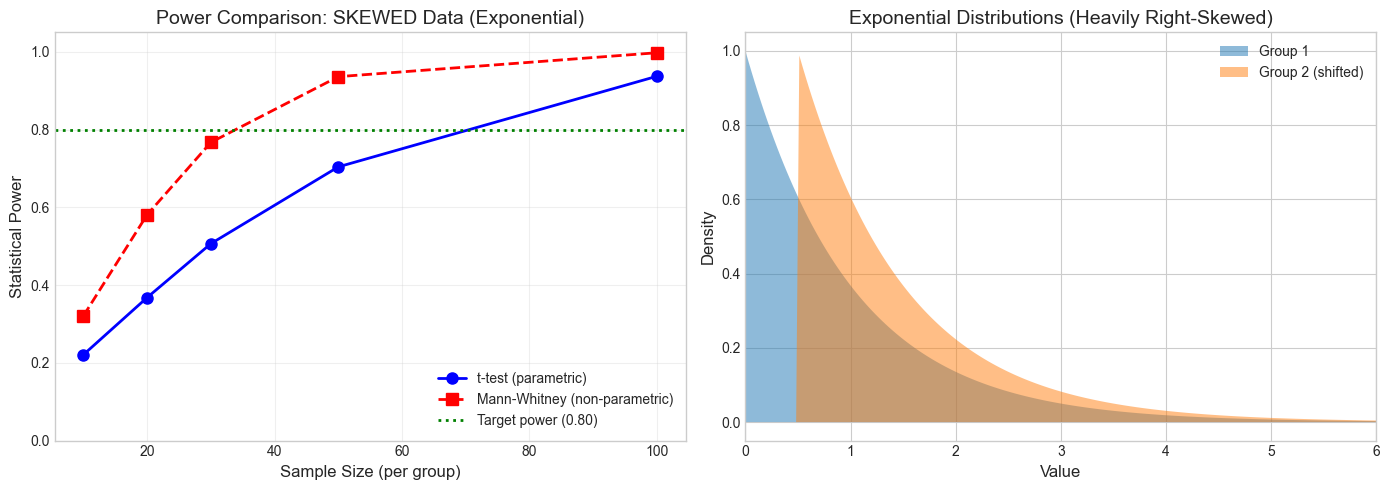


✓ With skewed data, Mann-Whitney outperforms the t-test!
  The t-test's assumptions are violated, reducing its effectiveness


In [7]:
# Visualize the comparison for skewed data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Power curves
ax1 = axes[0]
sizes = [r[0] for r in results_skewed]
power_t = [r[1] for r in results_skewed]
power_mw = [r[2] for r in results_skewed]

ax1.plot(sizes, power_t, 'b-o', linewidth=2, markersize=8, label='t-test (parametric)')
ax1.plot(sizes, power_mw, 'r--s', linewidth=2, markersize=8, label='Mann-Whitney (non-parametric)')
ax1.axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Target power (0.80)')
ax1.set_xlabel('Sample Size (per group)', fontsize=12)
ax1.set_ylabel('Statistical Power', fontsize=12)
ax1.set_title('Power Comparison: SKEWED Data (Exponential)', fontsize=14)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Plot 2: Example skewed distributions
ax2 = axes[1]
x = np.linspace(0, 6, 200)
ax2.fill_between(x, stats.expon.pdf(x, scale=1), alpha=0.5, label='Group 1')
ax2.fill_between(x, stats.expon.pdf(x - 0.5, scale=1) * (x >= 0.5), alpha=0.5, label='Group 2 (shifted)')
ax2.set_xlabel('Value', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Exponential Distributions (Heavily Right-Skewed)', fontsize=14)
ax2.legend()
ax2.set_xlim(0, 6)

plt.tight_layout()
plt.show()

print("\n✓ With skewed data, Mann-Whitney outperforms the t-test!")
print("  The t-test's assumptions are violated, reducing its effectiveness")

## Part 3: Data with Outliers

Outliers can severely affect the t-test because it uses means and standard deviations.
Mann-Whitney is robust because ranks are not affected by extreme values.

In [8]:
def power_simulation_outliers(n_samples, effect_size, outlier_prob=0.1, outlier_multiplier=10,
                               n_simulations=1000, alpha=0.05):
    """
    Simulate power with normal data CONTAMINATED by outliers.
    """
    ttest_significant = 0
    mannwhitney_significant = 0
    
    for _ in range(n_simulations):
        # Generate normal data
        group1 = np.random.normal(0, 1, n_samples)
        group2 = np.random.normal(effect_size, 1, n_samples)
        
        # Add outliers to both groups
        outlier_mask1 = np.random.random(n_samples) < outlier_prob
        outlier_mask2 = np.random.random(n_samples) < outlier_prob
        group1[outlier_mask1] *= outlier_multiplier * np.random.choice([-1, 1], size=outlier_mask1.sum())
        group2[outlier_mask2] *= outlier_multiplier * np.random.choice([-1, 1], size=outlier_mask2.sum())
        
        # Parametric: t-test
        _, p_ttest = stats.ttest_ind(group1, group2)
        if p_ttest < alpha:
            ttest_significant += 1
        
        # Non-parametric: Mann-Whitney U
        _, p_mannwhitney = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if p_mannwhitney < alpha:
            mannwhitney_significant += 1
    
    power_ttest = ttest_significant / n_simulations
    power_mannwhitney = mannwhitney_significant / n_simulations
    
    return power_ttest, power_mannwhitney

In [9]:
# Demonstrate with outliers
print("DATA WITH OUTLIERS: Parametric vs Non-Parametric Power")
print("=" * 60)
print("\nData: Normal distributions with 10% outliers (10x magnitude)")
print("Effect size: Cohen's d = 0.5")
print("-" * 60)

sample_sizes = [10, 20, 30, 50, 100]
effect_size = 0.5

results_outliers = []
for n in sample_sizes:
    power_t, power_mw = power_simulation_outliers(n, effect_size, n_simulations=2000)
    results_outliers.append((n, power_t, power_mw))
    print(f"n = {n:3d}: t-test power = {power_t:.3f}, Mann-Whitney power = {power_mw:.3f}, "
          f"Difference = {power_mw - power_t:+.3f}")

print("\n→ Mann-Whitney is MORE ROBUST to outliers!")

DATA WITH OUTLIERS: Parametric vs Non-Parametric Power

Data: Normal distributions with 10% outliers (10x magnitude)
Effect size: Cohen's d = 0.5
------------------------------------------------------------
n =  10: t-test power = 0.070, Mann-Whitney power = 0.119, Difference = +0.049
n =  20: t-test power = 0.080, Mann-Whitney power = 0.221, Difference = +0.142
n =  30: t-test power = 0.111, Mann-Whitney power = 0.315, Difference = +0.204
n =  50: t-test power = 0.124, Mann-Whitney power = 0.513, Difference = +0.389
n = 100: t-test power = 0.167, Mann-Whitney power = 0.794, Difference = +0.627

→ Mann-Whitney is MORE ROBUST to outliers!


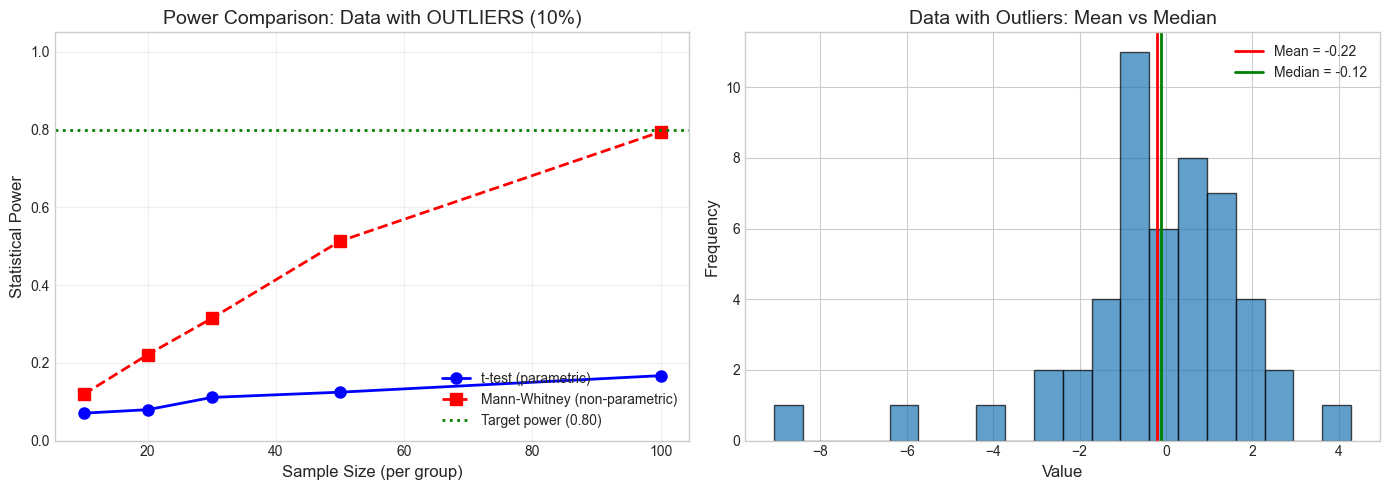


✓ Outliers pull the mean away from the center
  The median (used by rank-based tests) is unaffected!


In [10]:
# Visualize outlier contamination effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Power curves with outliers
ax1 = axes[0]
sizes = [r[0] for r in results_outliers]
power_t = [r[1] for r in results_outliers]
power_mw = [r[2] for r in results_outliers]

ax1.plot(sizes, power_t, 'b-o', linewidth=2, markersize=8, label='t-test (parametric)')
ax1.plot(sizes, power_mw, 'r--s', linewidth=2, markersize=8, label='Mann-Whitney (non-parametric)')
ax1.axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Target power (0.80)')
ax1.set_xlabel('Sample Size (per group)', fontsize=12)
ax1.set_ylabel('Statistical Power', fontsize=12)
ax1.set_title('Power Comparison: Data with OUTLIERS (10%)', fontsize=14)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Plot 2: Example data with outliers
ax2 = axes[1]
np.random.seed(123)
example_data = np.random.normal(0, 1, 50)
outlier_idx = np.random.choice(50, 5, replace=False)
example_data[outlier_idx] *= 10 * np.random.choice([-1, 1], size=5)

ax2.hist(example_data, bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(example_data), color='red', linewidth=2, label=f'Mean = {np.mean(example_data):.2f}')
ax2.axvline(np.median(example_data), color='green', linewidth=2, label=f'Median = {np.median(example_data):.2f}')
ax2.set_xlabel('Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Data with Outliers: Mean vs Median', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n✓ Outliers pull the mean away from the center")
print("  The median (used by rank-based tests) is unaffected!")

## Part 4: Summary Comparison

Let's compare all three scenarios side by side.

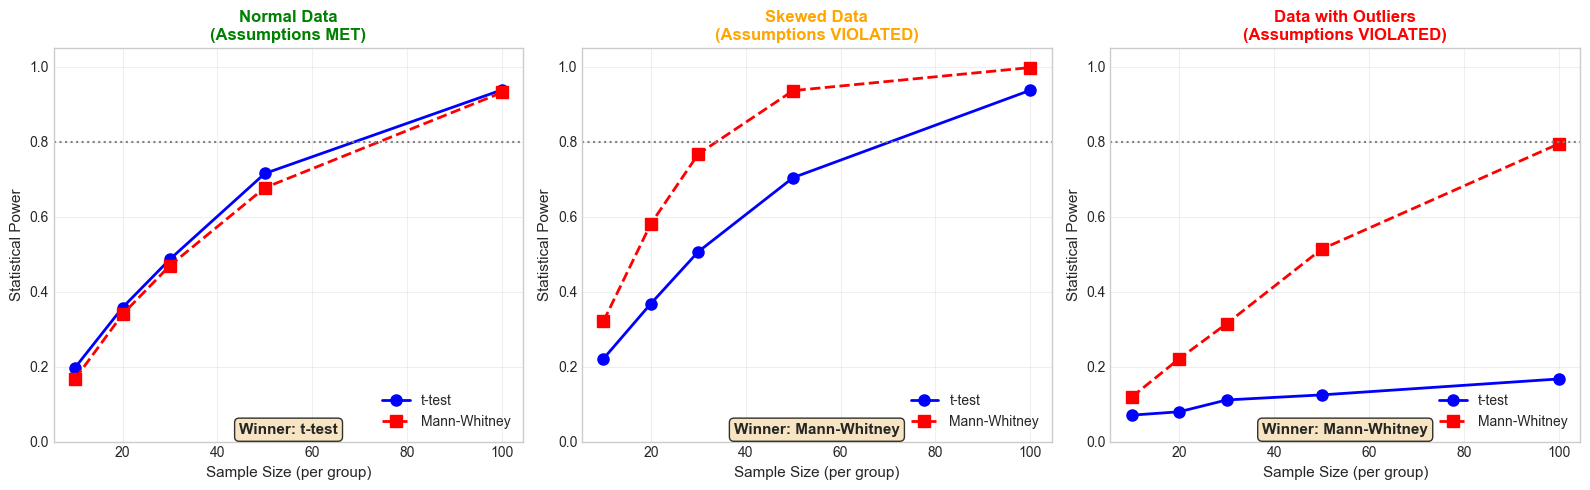

In [11]:
# Create comprehensive comparison figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

scenarios = [
    ('Normal Data\n(Assumptions MET)', results_normal, 'green'),
    ('Skewed Data\n(Assumptions VIOLATED)', results_skewed, 'orange'),
    ('Data with Outliers\n(Assumptions VIOLATED)', results_outliers, 'red')
]

for ax, (title, results, color) in zip(axes, scenarios):
    sizes = [r[0] for r in results]
    power_t = [r[1] for r in results]
    power_mw = [r[2] for r in results]
    
    ax.plot(sizes, power_t, 'b-o', linewidth=2, markersize=8, label='t-test')
    ax.plot(sizes, power_mw, 'r--s', linewidth=2, markersize=8, label='Mann-Whitney')
    ax.axhline(y=0.8, color='gray', linestyle=':', linewidth=1.5)
    ax.set_xlabel('Sample Size (per group)', fontsize=11)
    ax.set_ylabel('Statistical Power', fontsize=11)
    ax.set_title(title, fontsize=12, color=color, fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    
    # Shade winner region
    winner = 't-test' if np.mean(power_t) > np.mean(power_mw) else 'Mann-Whitney'
    ax.text(0.5, 0.02, f'Winner: {winner}', transform=ax.transAxes, 
            ha='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [12]:
# Quantify power advantage
print("POWER ADVANTAGE SUMMARY")
print("=" * 70)
print("\nAverage power at n=30 for each scenario:")
print("-" * 70)

# Get n=30 results
n30_normal = [r for r in results_normal if r[0] == 30][0]
n30_skewed = [r for r in results_skewed if r[0] == 30][0]
n30_outliers = [r for r in results_outliers if r[0] == 30][0]

print(f"{'Scenario':<30} {'t-test':>10} {'Mann-Whitney':>15} {'Better Test':>15}")
print("-" * 70)
print(f"{'Normal data (assumptions met)':<30} {n30_normal[1]:>10.3f} {n30_normal[2]:>15.3f} {'t-test':>15}")
print(f"{'Skewed data':<30} {n30_skewed[1]:>10.3f} {n30_skewed[2]:>15.3f} {'Mann-Whitney':>15}")
print(f"{'Data with outliers':<30} {n30_outliers[1]:>10.3f} {n30_outliers[2]:>15.3f} {'Mann-Whitney':>15}")

print("\n" + "=" * 70)
print("CONCLUSION:")
print("-" * 70)
print("• When assumptions ARE MET     → Use PARAMETRIC tests (more powerful)")
print("• When assumptions are VIOLATED → Use NON-PARAMETRIC tests (more robust)")
print("\nThe ~5% power loss of non-parametric tests under normality is the")
print("'price' you pay for robustness against assumption violations.")

POWER ADVANTAGE SUMMARY

Average power at n=30 for each scenario:
----------------------------------------------------------------------
Scenario                           t-test    Mann-Whitney     Better Test
----------------------------------------------------------------------
Normal data (assumptions met)       0.486           0.469          t-test
Skewed data                         0.506           0.767    Mann-Whitney
Data with outliers                  0.111           0.315    Mann-Whitney

CONCLUSION:
----------------------------------------------------------------------
• When assumptions ARE MET     → Use PARAMETRIC tests (more powerful)
• When assumptions are VIOLATED → Use NON-PARAMETRIC tests (more robust)

The ~5% power loss of non-parametric tests under normality is the
'price' you pay for robustness against assumption violations.


## Part 5: Asymptotic Relative Efficiency (ARE)

The theoretical efficiency of Mann-Whitney compared to t-test under normality is:

$$ARE = \frac{3}{\pi} \approx 0.955$$

This means Mann-Whitney needs about **5% more samples** to achieve the same power as the t-test when data is truly normal.

However, with non-normal data, Mann-Whitney can be **infinitely more efficient** than the t-test!

In [13]:
# Demonstrate the ARE concept
print("ASYMPTOTIC RELATIVE EFFICIENCY (ARE)")
print("=" * 60)
print(f"\nTheoretical ARE of Mann-Whitney vs t-test: 3/π ≈ {3/np.pi:.4f}")
print("\nInterpretation:")
print("-" * 60)
print("• Under normality: Mann-Whitney needs ~5% larger samples")
print("• Example: If t-test needs n=100, Mann-Whitney needs n=105")
print("\nBut this small cost provides INSURANCE against:")
print("• Non-normal distributions")
print("• Outliers")
print("• Heavy-tailed data")

ASYMPTOTIC RELATIVE EFFICIENCY (ARE)

Theoretical ARE of Mann-Whitney vs t-test: 3/π ≈ 0.9549

Interpretation:
------------------------------------------------------------
• Under normality: Mann-Whitney needs ~5% larger samples
• Example: If t-test needs n=100, Mann-Whitney needs n=105

But this small cost provides INSURANCE against:
• Non-normal distributions
• Outliers
• Heavy-tailed data


## Practical Guidelines

| Situation | Recommended Test | Reason |
|-----------|-----------------|--------|
| Large sample (n > 30), roughly normal | **t-test** | More powerful, CLT helps |
| Small sample, confirmed normal | **t-test** | Uses all information |
| Skewed data | **Mann-Whitney** | Robust to non-normality |
| Outliers present | **Mann-Whitney** | Not affected by extreme values |
| Ordinal data | **Mann-Whitney** | Appropriate for ranks |
| Unsure about distribution | **Mann-Whitney** | Safe choice with minimal power loss |

In [14]:
print("KEY TAKEAWAYS")
print("=" * 60)
print()
print("1. PARAMETRIC TESTS (e.g., t-test):")
print("   ✓ More powerful when assumptions hold")
print("   ✓ Use full information in the data")
print("   ✗ Can fail badly when assumptions violated")
print()
print("2. NON-PARAMETRIC TESTS (e.g., Mann-Whitney):")
print("   ✓ Robust to non-normality and outliers")
print("   ✓ Valid for any continuous distribution")
print("   ✗ Slightly less powerful (~5%) under normality")
print()
print("3. PRACTICAL ADVICE:")
print("   • Check your data distribution before choosing a test")
print("   • Use Q-Q plots or Shapiro-Wilk test for normality")
print("   • When in doubt, non-parametric is the safer choice")
print("   • With large samples (n > 30), CLT makes t-test robust")

KEY TAKEAWAYS

1. PARAMETRIC TESTS (e.g., t-test):
   ✓ More powerful when assumptions hold
   ✓ Use full information in the data
   ✗ Can fail badly when assumptions violated

2. NON-PARAMETRIC TESTS (e.g., Mann-Whitney):
   ✓ Robust to non-normality and outliers
   ✓ Valid for any continuous distribution
   ✗ Slightly less powerful (~5%) under normality

3. PRACTICAL ADVICE:
   • Check your data distribution before choosing a test
   • Use Q-Q plots or Shapiro-Wilk test for normality
   • When in doubt, non-parametric is the safer choice
   • With large samples (n > 30), CLT makes t-test robust
